## notebook for plotting the citation patterns of a single conference

revisions from v0:

* DONE - fix venue name entry: CoRR
* DONE - have venue name indicate conf or journal (-c, -j suffix) 
* clean up the data structure and groupbys 
* normalize heatmaps, compute entropy
* export one single graph for incoming/outgoing citations
* generate network layout for the graph above
* DONE - auto save and name the plots

processing

* figs for PLDI
* figs for ML conferences
* figs for ACM MM

* new MAG data


In [79]:
import os, sys
import pandas as pd
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import pickle

# initilize plotting packages: seaborn

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline

#conf = 'WSDM'
conf = 'PLDI'
data_dir = './data'
plot_dir = './plots'

input data: 

* dataframes: paper, citing, cited
* conference + journal --> df_venue, displaynames

In [80]:
d = pickle.load( open(os.path.join(data_dir, 'cite_records.'+conf+".pkl"), 'rb') )
# pickle.dump({"name":c, 'citing':dfx_citing, "cited":dfx_cited, "paper":df_paper}, 
#           open(os.path.join(data_dir, 'cite_records.'+c+".pkl"), 'wb') ) 

df_citing = d['citing']
df_cited = d['cited']
df_paper = d['paper']

print(len(df_paper), len(df_citing), len(df_cited))

1091 30155 65375


In [81]:
conf_file = os.path.join(data_dir, 'ConferenceSeries.txt')
conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])

jnl_file = os.path.join(data_dir, 'Journals.txt')
jnl_df = pd.read_table(jnl_file, header=None, names=['JournalID', 'FullName'])

print("{} conferences and {} journals found in db".format(len(conf_df), len(jnl_df)) )

num_conf = len(conf_df)

df_venue = pd.concat([ conf_df[['ConfID', 'Abbrv']].rename(columns = {'Abbrv':'VenueName', 'ConfID':"VenueID"}), 
                    jnl_df.rename(columns = {'FullName':'VenueName', 'JournalID':"VenueID"}, 
                                  index = dict(zip(list(jnl_df.index), [x+num_conf for x in list(jnl_df.index)])), 
                                  inplace=False) ], 
                    keys=['c', 'j'])

print( df_venue.head() ) 
print (df_venue.tail())
print(len(df_venue))


1275 conferences and 23568 journals found in db
      VenueID VenueName
c 0  4333BBB9      AISM
  1  439E92D8      DAIS
  2  43CD1EFB     ADBIS
  3  43FD0CAC      ICCL
  4  44195980     ATMOS
          VenueID                                          VenueName
j 24838  3B5DC685                    Handbook of Practice Management
  24839  3C41C698         Slovak Review of World Literature Research
  24840  3CA92478  Revue Internationale De Psychologie Sociale-in...
  24841  3CC4EBBB                                 Arheoloski Vestnik
  24842  3D56EA66                 Monatsschrift Fur Brauwissenschaft
24843


In [82]:
"""correct one acronym err as per discusion with Alex Wade at MSR -- 2016-02-24
Clinical Orthopaedics and Related Research  --> CoRR
"""

ifix = np.nonzero(df_venue['VenueName'] == "Clinical Orthopaedics and Related Research" )[0]
print("changing this entry: ")
print( df_venue.iloc[ ifix] ) 
print("to this entry: ")
df_venue.set_value(('j', ifix[0]), 'VenueName', 'CoRR')
print( df_venue.iloc[ifix] ) 


changing this entry: 
          VenueID                                   VenueName
j 13538  0B68DB42  Clinical Orthopaedics and Related Research
to this entry: 
          VenueID VenueName
j 13538  0B68DB42      CoRR


In [83]:
""" now generate dictionaries for display names: ID--> display; and VenueName--> display
"""
id2display = dict.fromkeys(list(df_venue['VenueID']))
name2display = dict.fromkeys(list(df_venue['VenueName']))

cnt = 0 
for index, row in df_venue.iterrows():
    v = row['VenueID']
    m = row['VenueName']
    m1 = m.replace('The Journal of', 'J.').replace('Journal of', 'J.').replace('Journal', 'J')
    m2 = m1.replace('Proceedings of', 'Proc.').replace('Proceedings', 'Proc')
    m3 = m2.replace('Annals of', 'A.').replace('Annals', 'A')
    m3 = m3.replace('Review', 'Rev').replace('Transactions', 'Trans')
    m3 = m3.replace('International', 'Intl').replace('National', 'Nat')
    m4 = m3 if len(m3)<=25 else m3[:23]+".."
    ds = m4+"-"+index[0]
    id2display[v] = ds
    name2display[m] = ds
    cnt += 1
    #if cnt>=24800: 
    #    print([v, m, ds])

In [84]:
print( df_paper.head() )
print( df_citing.head() )
print( df_cited.head() )

    PaperID                                          TitleOrig  \
0  0222612B  The essence of compiling with continuations (w...   
1  0BB54A65                        Types for atomic interfaces   
2  08233E7D  Static Debugging: Browsing the Web of Program ...   
3  5F036B00  Merlin (specification inference for explicit i...   
4  651C728A  Shape analysis with inductive recursion synthesis   

                                           TitleNorm  PubYear     PubDate  \
0  the essence of compiling with continuations wi...     1993         NaN   
1                        types for atomic interfaces     2002         NaN   
2  static debugging browsing the web of program i...     1996         NaN   
3  merlin specification inference for explicit in...     2009  2009/06/15   
4  shape analysis with inductive recursion synthesis     2007  2007/06/15   

   DOI                                       VenueOrig VenueNorm  JournalID  \
0  NaN  Programming Language Design and Implementation      p

In [86]:
refyear_citing = df_citing.groupby(['PaperPubYear', 'RefPubYear'], sort=True)
refyear_citing['RefID'].count()
print( np.unique(df_paper['PubYear'] ) ) 
print( np.unique(df_citing['PaperPubYear'] ) ) 
print( np.unique(df_citing['RefPubYear'] ) )

[1979 1982 1984 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015]
[1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
[1865 1927 1936 1937 1938 1940 1941 1945 1951 1952 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [87]:
paper_years = np.unique(df_citing['PaperPubYear'] )
paper_count = df_paper['PubYear'].value_counts(sort=False)[paper_years]

ref_pp = np.array( df_citing['PaperPubYear'].value_counts(sort=False)[paper_years]/paper_count )
cit_pp = np.array( df_cited['RefPubYear'].value_counts(sort=False)[paper_years]/paper_count )

print(paper_years)
print(paper_count.head())
print( ref_pp[:5])
print( cit_pp[:5])

[1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]
1988    41
1989    39
1990    35
1991    37
1992    35
Name: PubYear, dtype: int64
[ 21.17073171  17.51282051  20.05714286  23.54054054  18.91428571]
[ 120.           55.20512821   86.6          87.94594595   48.11428571]


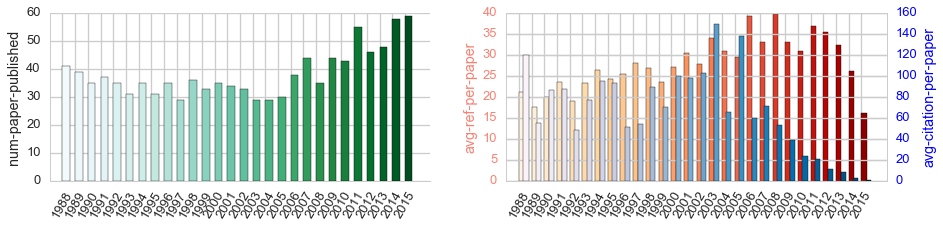

In [88]:
# data profile: # of papers published per year, citations per year

plt.figure(figsize=(15, 3))
cur_dpi=100
# # of papers over years; # of references and # of citations over years
# # of citings over years, w/wo venues; # of citing venues over years
# # of citations over publication years, w/wo venues; # of venues over years

bar_colrs1 = sns.color_palette("BuGn", len(paper_years))
bar_colrs2 = sns.color_palette("OrRd", len(paper_years))
bar_colrs3 = sns.color_palette("PuBu", len(paper_years))
x_pos = [x+1 for x in range(len(paper_years))]

"""# papers per year"""

sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")
sns.despine()

ax = plt.subplot(1, 2, 1)

rects1 = ax.bar(x_pos, np.array(paper_count), width=.6, color=bar_colrs1)
ax.set_ylabel('num-paper-published')
tk1 = plt.xticks(x_pos, paper_years, rotation=60) 

"""# of references and # of citations over years"""
ax2 = plt.subplot(1, 2, 2)

sns.set_style("whitegrid")
sns.despine()

rects2 = ax2.bar(x_pos, ref_pp, width=.4, color=bar_colrs2)

ax2a = ax2.twinx()
rects2a = ax2a.bar([x+.35 for x in x_pos], cit_pp, width=.4, color=bar_colrs3)

tk2 = plt.xticks([],[])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(paper_years, rotation=60)

ax2.set_ylabel('avg-ref-per-paper', color='salmon')
ax2a.set_ylabel('avg-citation-per-paper', color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('salmon')
for tl in ax2a.get_yticklabels():
    tl.set_color('b') 

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_paper.png'), dpi=cur_dpi, transparent=True)    

[491, 341, 376, 430, 372, 444, 535, 435, 492, 460, 545, 474, 549, 593, 510, 543, 529, 505, 870, 876, 879, 868, 823, 1317, 1093, 967, 909, 573] [377, 342, 326, 441, 290, 276, 387, 320, 397, 356, 426, 304, 402, 445, 409, 448, 367, 381, 622, 585, 512, 593, 508, 720, 545, 585, 616, 376]


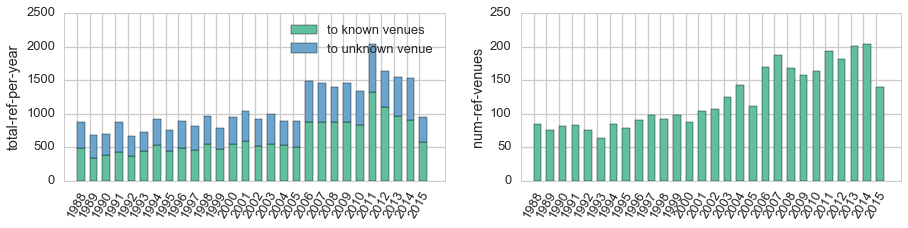

In [89]:
"""# of citings over years, w/wo venues; # of citing venues over years"""    
plt.figure(figsize=(15, 3))

ax3 = plt.subplot(1, 2, 1)
sns.set_context("talk", font_scale=1.)
sns.set_style("whitegrid")

citing_not_null = [] #np.zeros((1, len(years)), dtype=np.int)
citing_num_null = [] #np.zeros((len(years), 1), dtype=np.int)
cnt = 0 
for name, gf in df_citing.groupby(['PaperPubYear']):
    #print(gf.head())
    #print(len(gf), len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ), len ( gf['RefVenueID'][gf['RefVenueID'] == ''] )) 
    citing_not_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] != ''] ) )
    citing_num_null.append( len ( gf['RefVenueID'][gf['RefVenueID'] == ''] ) )
    
print(citing_not_null, citing_num_null)    
idx = int(len(bar_colrs1)/2)
rects3a = ax3.bar(x_pos, citing_not_null, width=.6, color=bar_colrs1[idx])
rects3b = ax3.bar(x_pos, citing_num_null, width=.6, color=bar_colrs3[idx], bottom=citing_not_null)

tk3 = plt.xticks(x_pos, paper_years, rotation=60) 
ax3.set_ylabel('total-ref-per-year')
plt.legend((rects3a[0], rects3b[0]), ('to known venues', 'to unknown venue'))

ax4 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = []
for name, gf in df_citing[df_citing['RefVenueID'] != ''].groupby(['PaperPubYear']):
    venue_counts.append( len( gf['RefVenueID'].value_counts() ) )

rects4 = ax4.bar(x_pos, venue_counts, width=.6, color=bar_colrs1[idx])

tk4 = plt.xticks(x_pos, paper_years, rotation=60)
ax4.set_ylabel('num-ref-venues')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_ref.png'), dpi=cur_dpi, transparent=True)    

[2471, 1159, 1540, 1669, 894, 1187, 1634, 1436, 825, 775, 1468, 1121, 1614, 1562, 1668, 1988, 965, 1966, 1140, 1473, 935, 759, 420, 454, 192, 130, 63, 8] [2449, 994, 1491, 1585, 790, 1214, 1712, 1454, 960, 799, 1736, 1202, 1885, 1770, 1723, 2348, 945, 2181, 1119, 1645, 936, 965, 574, 679, 325, 280, 90, 4]
28 28


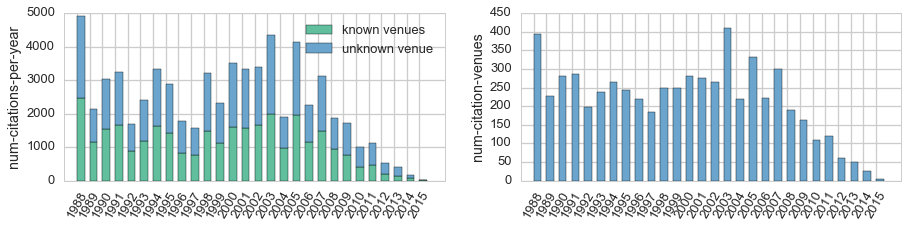

In [90]:
"""# of citations over publication years, w/wo venues; # of venues over years"""

plt.figure(figsize=(15, 3))

ax5 = plt.subplot(1, 2, 1)
sns.set_style("whitegrid")

citations_not_null = [] 
citations_num_null = [] 
for name, gf in df_cited.groupby(['RefPubYear']):
    #print(gf.head())
    # print(name, len(gf), len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ), len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] )) 
    if name in paper_years:    
        citations_not_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] != ''] ) )
        citations_num_null.append( len ( gf['PaperVenueID'][gf['PaperVenueID'] == ''] ) )
    
print(citations_not_null, citations_num_null)
print(len(citations_not_null), len(citations_num_null))

idx = int(len(bar_colrs1)/2)
rects5a = ax5.bar(x_pos, citations_not_null, width=.6, color=bar_colrs1[idx])
rects5b = ax5.bar(x_pos, citations_num_null, width=.6, color=bar_colrs3[idx], bottom=citations_not_null)

tk5 = plt.xticks(x_pos, paper_years, rotation=60) 
ax5.set_ylabel('num-citations-per-year')
plt.legend((rects5a[0], rects5b[0]), ('known venues', 'unknown venue'))

ax6 = plt.subplot(1, 2, 2)
sns.set_style("whitegrid")

venue_counts = []
for name, gf in df_cited[df_cited['PaperVenueID'] != ''].groupby(['RefPubYear']):
    if name in paper_years:    
        venue_counts.append( len( gf['PaperVenueID'].value_counts() ) )

rects6 = ax6.bar(x_pos, venue_counts, width=.6, color=bar_colrs3[idx])

tk6 = plt.xticks(x_pos, paper_years, rotation=60)
ax6.set_ylabel('num-citation-venues')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_cnt_citation.png'), dpi=cur_dpi, transparent=True)    

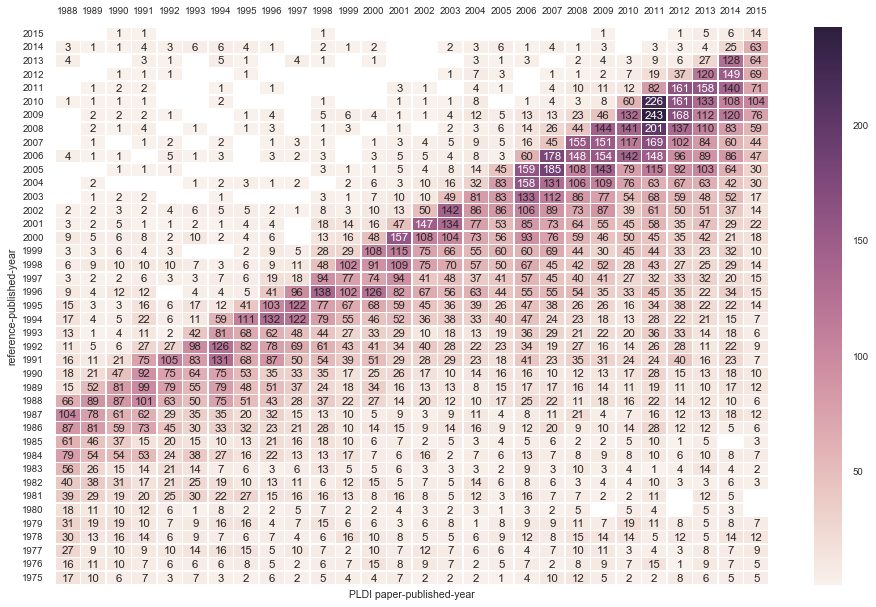

In [91]:
print('{} paper papers from {} to {}, citing {} others, avg {:0.2f} references per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_citing), len(df_citing)/len(df_paper)))
grouped_citing = df_citing.groupby(['PaperPubYear'], sort=True)
grouped_citing.count()
len(grouped_citing)

refpubyear_count = pd.DataFrame(data=None, index=np.unique(df_citing['RefPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_citing:
    if name in paper_years:    
        refpubyear_count[name] = gf['RefPubYear'].value_counts(sort=True)
    #print("{}: {} references across {} years".format(name, len(gf), len(gf['RefPubYear'].value_counts())) )

plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

""" # the view of everthing
sns.heatmap(refpubyear_count, linewidths=.5, yticklabels=3)
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')
"""

# the subset of reference years
ax = sns.heatmap(refpubyear_count.loc[1975:2015], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
ax.xaxis.tick_top()
ax.invert_yaxis()
sns.axlabel(conf + ' paper-published-year', 'reference-published-year')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_year_ref.png'), transparent=True)


1091 paper papers from 1979 to 2015, cited 65375 time, avg 59.92 cites per paper


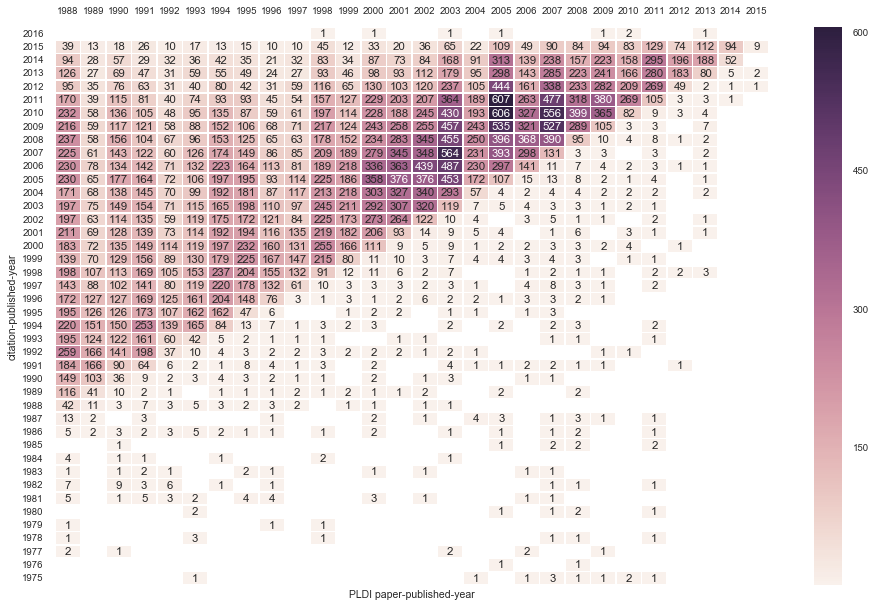

In [92]:
print('{} paper papers from {} to {}, cited {} time, avg {:0.2f} cites per paper'.format(
        len(df_paper), df_paper['PubYear'].min(), df_paper['PubYear'].max(), len(df_cited), len(df_cited)/len(df_paper)))
grouped_cited = df_cited.groupby(['RefPubYear'], sort=True)
#print( grouped_cited.count() )
#len(grouped_cited)

cite_pubyear_count = pd.DataFrame(data=None, index=np.unique(df_cited['PaperPubYear'] ), 
                                    columns=paper_years, dtype='int32')
for name, gf in grouped_cited:
    if name in paper_years:    
        cite_pubyear_count[name] = gf['PaperPubYear'].value_counts(sort=True)
    #print("{}: {} citations across {} years".format(name, len(gf), len(gf['PaperPubYear'].value_counts())) )
 
plt.figure(figsize=(16, 10))
sns.set_context("poster", font_scale=0.6) #rc={"lines.linewidth": 2.5}

ax = sns.heatmap(cite_pubyear_count.loc[1975:2016], linewidths=.5, annot=True, fmt=".0f") # annot=True, fmt="d", 
sns.axlabel(conf + ' paper-published-year', 'citation-published-year')
ax.xaxis.tick_top()
ax.invert_yaxis()

plt.savefig(os.path.join(plot_dir, conf.lower()+'_citation_year.png'), transparent=True)


In [ ]:
""" refs and citation data frames
PaperID     RefID  PaperPubYear  PaperConfID  RefPubYear RefVenueID
0  01C7AF88  5DF47FD5          2014      4332078        2005           
1  0419D273  69802989          2013      4332078        1983           
2  04C8255A  707FA05D          2011      4332078        2008   46A355BA
3  06E27F4E  5D781F7D          2014      4332078        2000    5686292
4  07E16ECA  5ACD83EA          2012      4332078        2005   4332078E

PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID
0  0007A307  6F46CC0D        2000    4332078          2003             
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3
2  002545D4  685D7FC2        1999    4332078          2005             
3  002E73A6  6978437E        2007    4332078          2009             
4  004344D3  5CCE3A13        1990    4332078          1991             

goal of this sec: groupby venue and count
"""

gv_citing = df_citing.groupby(['RefVenueID'])


In [133]:
""" template for left joins
dfx_cited = df_cited.merge(df_paper[['PaperID', 'PubYear', 'ConfID']], 
                           left_on="RefID", right_on='PaperID', how='left') 
dfx_cited.drop('PaperID_y', axis=1, inplace=True)
dfx_cited = dfx_cited.rename(columns = {'PubYear':'RefPubYear', 'ConfID':"RefConfID", "PaperID_x":"PaperID"})
"""
# conf_df = pd.read_table(conf_file, header=None, names=['ConfID', 'Abbrv', 'FullName'])
dfx_citing = df_citing.merge(df_venue, left_on='RefVenueID', right_on='VenueID', how='left')
dfx_citing.drop('VenueID', axis=1, inplace=True)
dfx_citing = dfx_citing.rename(columns = {'VenueName':'RefVenueName'})

dfx_citing.head(10)

,PaperID,RefID,PaperPubYear,PaperConfID,RefPubYear,RefVenueID,RefVenueName
0,01C7AF88,5DF47FD5,2014,4332078,2005,,NaN
1,0419D273,69802989,2013,4332078,1983,,NaN
2,04C8255A,707FA05D,2011,4332078,2008,46A355BA,OSDI
3,06E27F4E,5D781F7D,2014,4332078,2000,5686292,NaN
4,07E16ECA,5ACD83EA,2012,4332078,2005,4332078E,PLDI
5,08581911,6CA51D9F,2013,4332078,2009,4332078E,PLDI
6,0929E3D5,00D06498,2014,4332078,1978,0867CDAD,Journal of Computer and System Sciences
7,095CDFAE,5F6B5260,2014,4332078,2006,02FC069B,Operating Systems Review
8,0A6B7A85,6F3402CE,2014,4332078,2013,,NaN
9,0A89CF72,639067C2,2014,4332078,1996,0A0DDB5F,IEEE Transactions on Signal Processing


In [134]:
is_empty = dfx_citing['RefVenueID'] == ''
is_empty.value_counts()

False    17799
True     12356
Name: RefVenueID, dtype: int64

In [135]:
dfx_citing_valid = dfx_citing[dfx_citing['RefVenueID'] != '']
dfx_citing_valid.tail()

,PaperID,RefID,PaperPubYear,PaperConfID,RefPubYear,RefVenueID,RefVenueName
30150,707942CE,586C8519,2008,4332078,1987,0965DDD6,IEEE Transactions on Computers
30151,707942CE,5F4E9180,2008,4332078,2004,0B0C7BA0,ACM Transactions on Graphics
30152,70A965CE,5DD4107C,2003,4332078,1993,01ED449B,The Journal of Supercomputing
30153,70B8EC35,5AAF35A1,1996,4332078,1995,027877C6,ACM Transactions on Programming Languages and ...
30154,70BB78FD,59D438C5,1996,4332078,1991,039952EE,ACM Sigarch Computer Architecture News


In [136]:
venue_name = list(dfx_citing_valid['RefVenueName'].unique())

grouped_citing = dfx_citing_valid.groupby(['PaperPubYear'], sort=True)
#print( grouped_citing.count() )
#len(grouped_cited)

citing_venue_count = pd.DataFrame(data=None, index = venue_name, 
                                    columns=np.unique(dfx_citing_valid['PaperPubYear']), dtype='int32')
for name, gf in grouped_citing:

    citing_venue_count[name] = gf['RefVenueName'].value_counts(sort=True)
    #print (citing_venue_count[name][citing_venue_count[name].notnull()])
    print("{}: {} references across {} venues".format(name, len(gf), citing_venue_count[name].notnull().sum() ) )
    #break
 


1988: 491 references across 83 venues
1989: 341 references across 73 venues
1990: 376 references across 77 venues
1991: 430 references across 79 venues
1992: 372 references across 70 venues
1993: 444 references across 59 venues
1994: 535 references across 80 venues
1995: 435 references across 75 venues
1996: 492 references across 84 venues
1997: 460 references across 92 venues
1998: 545 references across 88 venues
1999: 474 references across 90 venues
2000: 549 references across 83 venues
2001: 593 references across 101 venues
2002: 510 references across 100 venues
2003: 543 references across 117 venues
2004: 529 references across 136 venues
2005: 505 references across 107 venues
2006: 870 references across 159 venues
2007: 876 references across 177 venues
2008: 879 references across 158 venues
2009: 868 references across 148 venues
2010: 823 references across 155 venues
2011: 1317 references across 178 venues
2012: 1093 references across 172 venues
2013: 967 references across 189 venu

In [137]:
total_cnt = dfx_citing_valid.groupby(['RefVenueName']).count()['PaperID'].copy()
total_cnt.head(10)
total_cnt.sort_values(ascending=False, inplace=True)

['PLDI', 'POPL', 'ACM Transactions on Programming Languages and Systems', 'Sigplan Notices', 'Communications of The ACM', 'ASPLOS', 'ICFP', 'PPoPP', 'IEEE Transactions on Computers', 'Software - Practice and Experience', 'Operating Systems Review', 'IEEE Transactions on Software Engineering', 'FSE', 'CAV', 'ICS', 'Journal of the ACM', 'ACM Sigarch Computer Architecture News', 'IEEE Computer', 'ECOOP', 'CC', 'MICRO', 'ICSE', 'OSDI', 'LCPC', 'IEEE Micro', 'Science of Computer Programming', 'IEEE Transactions on Parallel and Distributed Systems', 'ACM Transactions on Computer Systems', 'International Journal of Parallel Programming', 'OOPSLA', 'ACM Computing Surveys', 'TACAS', 'Journal of Functional Programming', 'Journal of Parallel and Distributed Computing', 'ESOP', 'PACT', 'Proceedings of the IEEE', 'ISMM', 'ICPP', 'Journal of the Operational Research Society', 'S&P', 'SPAA', 'PODC', 'CoRR', 'Computational Complexity', 'Journal of Computer and System Sciences', 'ASE', 'The Journal of 

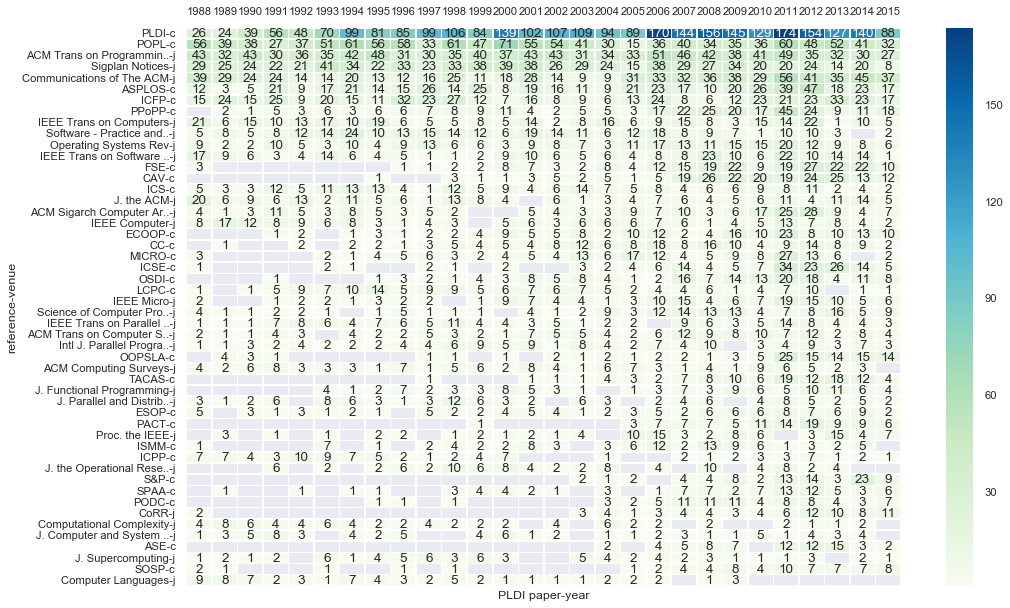

In [140]:
#total_cnt.head(50)
#print(list(total_cnt.index))
#for s in total_cnt:
    #print('{} \t {}'.format(srs, idx))
#    print(s)

# figure out the top X venues for display
topK = 50
venue_list = list(total_cnt.index)[:topK]
print(venue_list)


sns.set_context("poster", font_scale=0.7)
plt.figure(figsize=(16, 10))
ax = sns.heatmap(citing_venue_count.loc[venue_list], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
sns.axlabel(conf + ' paper-year', 'reference-venue')
venue_name = [name2display[v] for v in venue_list]
yt = ax.set_yticklabels(venue_name[::-1])

plt.savefig(os.path.join(plot_dir, conf.lower()+'_ref_venue.png'), transparent=True)

In [141]:
# now the citing articles

dfx_cited = df_cited.merge(df_venue, left_on='PaperVenueID', right_on='VenueID', how='left')
dfx_cited.drop('VenueID', axis=1, inplace=True)
dfx_cited = dfx_cited.rename(columns = {'VenueName':'PaperVenueName'})

print( dfx_cited.head() )

is_empty = dfx_cited['PaperVenueID'] == ''
print( is_empty.value_counts() ) 

dfx_cited_valid = dfx_cited[dfx_cited['PaperVenueID'] != '']
dfx_cited_valid.tail()

    PaperID     RefID  RefPubYear  RefConfID  PaperPubYear PaperVenueID  \
0  0007A307  6F46CC0D        2000    4332078          2003                
1  001D62B0  5C4CC440        2002    4332078          2014     0140E2D3   
2  002545D4  685D7FC2        1999    4332078          2005                
3  002E73A6  6978437E        2007    4332078          2009                
4  004344D3  5CCE3A13        1990    4332078          1991                

                    PaperVenueName  
0                              NaN  
1  Science of Computer Programming  
2                              NaN  
3                              NaN  
4                              NaN  
True     33857
False    31518
Name: PaperVenueID, dtype: int64


,PaperID,RefID,RefPubYear,RefConfID,PaperPubYear,PaperVenueID,PaperVenueName
65364,7088A8B7,6CD63D17,1989,4332078,2003,0880543B,ACM Transactions on Software Engineering and M...
65368,709BBDB8,6E29E827,2010,4332078,2010,430D9705,ISSTA
65370,70A776CF,6E2557C5,1994,4332078,2006,041D69C4,Journal of Embedded Computing
65371,70AD3DA1,67174FC2,1997,4332078,2012,0965DDD6,IEEE Transactions on Computers
65372,70ADE0A5,69AF8833,2002,4332078,2006,430D9705,ISSTA


In [142]:
grouped_cited = dfx_cited_valid.groupby(['RefPubYear'], sort=True)

cited_venue_count = pd.DataFrame(data=None, index = venue_name, 
                                    columns=np.unique(dfx_cited_valid['RefPubYear']), dtype='int32')
for name, gf in grouped_cited:
    #grouped_citing.RefPubYear
    cited_venue_count[name] = gf['PaperVenueName'].value_counts(sort=True)
    print("{}: {} citiations across {} venues".format(name, len(gf), cited_venue_count[name].notnull().sum() ) )
    

1984: 1 citiations across 0 venues
1987: 1 citiations across 0 venues
1988: 2471 citiations across 0 venues
1989: 1159 citiations across 0 venues
1990: 1540 citiations across 0 venues
1991: 1669 citiations across 0 venues
1992: 894 citiations across 0 venues
1993: 1187 citiations across 0 venues
1994: 1634 citiations across 0 venues
1995: 1436 citiations across 0 venues
1996: 825 citiations across 0 venues
1997: 775 citiations across 0 venues
1998: 1468 citiations across 0 venues
1999: 1121 citiations across 0 venues
2000: 1614 citiations across 0 venues
2001: 1562 citiations across 0 venues
2002: 1668 citiations across 0 venues
2003: 1988 citiations across 0 venues
2004: 965 citiations across 0 venues
2005: 1966 citiations across 0 venues
2006: 1140 citiations across 0 venues
2007: 1473 citiations across 0 venues
2008: 935 citiations across 0 venues
2009: 759 citiations across 0 venues
2010: 420 citiations across 0 venues
2011: 454 citiations across 0 venues
2012: 192 citiations acros

In [144]:
total_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
total_cnt.sort_values(ascending=False, inplace=True)
#print(total_cnt.head(25), total_cnt.tail())

topK = 50
venue_list = list(total_cnt.index)[:topK]
print(venue_list)

sns.set_context("poster", font_scale=0.7)
plt.figure(figsize=(16, 10))
ax = sns.heatmap(cited_venue_count.loc[venue_list], linewidths=.5, annot=True, fmt=".0f", cmap="GnBu") 
ax.xaxis.tick_top()
venue_name = [name2display[v] for v in venue_list]
yt = ax.set_yticklabels(venue_name[::-1])
sns.axlabel(conf + ' paper-year', 'reference-venue')

plt.savefig(os.path.join(plot_dir, conf.lower()+'_citation_venue.png'), transparent=True)

['PLDI', 'ACM Transactions on Programming Languages and Systems', 'CC', 'ASPLOS', 'LCPC', 'FSE', 'ICSE', 'POPL', 'Sigplan Notices', 'ICFP', 'PACT', 'IEEE Transactions on Software Engineering', 'ICS', 'Software - Practice and Experience', 'PPoPP', 'Science of Computer Programming', 'International Journal of Parallel Programming', 'ECOOP', 'IEEE Transactions on Parallel and Distributed Systems', 'OOPSLA', 'CoRR', 'ASE', 'CAV', 'MICRO', 'IEEE Transactions on Computers', 'ISMM', 'ACM Sigarch Computer Architecture News', 'Euro-Par', 'SCAM', 'ESOP', 'ISSTA', 'Journal of Systems and Software', 'APLAS', 'Operating Systems Review', 'Journal of Parallel and Distributed Computing', 'The Journal of Supercomputing', 'ACM Transactions on Software Engineering and Methodology', 'ICPP', 'HPCA', 'ICSM', 'ACM Transactions in Embedded Computing Systems', 'Proceedings of the IEEE', 'PASTE', 'International Journal on Software Tools for Technology Transfer', 'S&P', 'ACM Computing Surveys', 'IEEE Transactions

KeyError: "None of [['PLDI', 'ACM Transactions on Programming Languages and Systems', 'CC', 'ASPLOS', 'LCPC', 'FSE', 'ICSE', 'POPL', 'Sigplan Notices', 'ICFP', 'PACT', 'IEEE Transactions on Software Engineering', 'ICS', 'Software - Practice and Experience', 'PPoPP', 'Science of Computer Programming', 'International Journal of Parallel Programming', 'ECOOP', 'IEEE Transactions on Parallel and Distributed Systems', 'OOPSLA', 'CoRR', 'ASE', 'CAV', 'MICRO', 'IEEE Transactions on Computers', 'ISMM', 'ACM Sigarch Computer Architecture News', 'Euro-Par', 'SCAM', 'ESOP', 'ISSTA', 'Journal of Systems and Software', 'APLAS', 'Operating Systems Review', 'Journal of Parallel and Distributed Computing', 'The Journal of Supercomputing', 'ACM Transactions on Software Engineering and Methodology', 'ICPP', 'HPCA', 'ICSM', 'ACM Transactions in Embedded Computing Systems', 'Proceedings of the IEEE', 'PASTE', 'International Journal on Software Tools for Technology Transfer', 'S&P', 'ACM Computing Surveys', 'IEEE Transactions on Computer-Aided Design of Integrated Circuits and Systems', 'Concurrency and Computation: Practice and Experience', 'VEE', 'Journal of Functional Programming']] are in the [index]"

In [94]:
cited_venue_count.index #loc[venue_list]

Index(['SIGIR-c', 'WWW-c', 'KDD-c', 'WSDM-c', 'CIKM-c', 'NIPS-c', 'CoRR-j',
       'ICML-c', 'CHI-c', 'ICDM-c', 'ACM Trans on Informatio..-j', 'ACL-c',
       'Communications of The ACM-j', 'J. Machine Learning Res..-j', 'EMNLP-c',
       'Information Processing ..-j', 'J. the Association for ..-j', 'AAAI-c',
       'J. the ACM-j', 'VLDB-c', 'Proc. The Vldb Endowment-j',
       'Proc. the Nal Academy o..-j', 'SIGMOD-c', 'Sigir Forum-j', 'ICWSM-c',
       'Information Retrieval-j', 'WI-c', 'IEEE Trans on Knowledge..-j',
       'Machine Learning-j', 'SODA-c', 'J. the American Statist..-j', 'UAI-c',
       'EC-c', 'STOC-c', 'World Wide Web-j', 'Technometrics-j',
       'Sigkdd Explorations-j', 'NAACL-c', 'IEEE Trans on Pattern A..-j',
       'RecSys-c', 'IEEE Computer-j', 'MM-c', 'Science-j',
       'Computer Networks-j', 'Physical Rev E-j',
       'Computer Networks and I..-j', 'ACM Computing Surveys-j', 'COLING-c',
       'Foundations and Trends ..-j', 'Data Mining and Knowled..-j'],
  

In [43]:
import networkx as nx

topK = 25

""" generate citation venue graph """
citation_venue_cnt = dfx_cited_valid.groupby(['PaperVenueName']).count()['PaperID'].copy()
citation_venue_cnt.sort_values(ascending=False, inplace=True)
citeG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(citation_venue_cnt.head(25).index), list(citation_venue_cnt.head(25))):
    citeG.add_edge(v, 'WSDM', weight= int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'citeG.graphml'))

""" generate reference venue graph """ 
ref_venue_cnt = dfx_citing_valid.groupby(['RefVenueName']).count()['PaperID'].copy()
ref_venue_cnt.sort_values(ascending=False, inplace=True)
refG = nx.DiGraph()

#for i in range(topK):
for v, c in zip(list(ref_venue_cnt.head(topK).index), list(ref_venue_cnt.head(topK))):
    refG.add_edge('WSDM', v, weight=int(c) )

nx.write_graphml(citeG, os.path.join(data_dir, 'refG.graphml'))


In [44]:
len(citation_venue_cnt)

710

In [45]:
citation_venue_cnt.head(25)

PaperVenueName
WWW                                                                  399
SIGIR                                                                391
WSDM                                                                 354
KDD                                                                  219
CIKM                                                                 103
Information Processing and Management                                 97
Expert Systems With Applications                                      89
WI                                                                    79
ICDM                                                                  75
Information Retrieval                                                 68
ACM Transactions on Information Systems                               64
Journal of the Association for Information Science and Technology     63
Proceedings of The Vldb Endowment                                     60
Clinical Orthopaedics and Related Re

In [46]:
ref_venue_cnt.head(topK)

RefVenueName
SIGIR                                                                              997
WWW                                                                                781
KDD                                                                                567
WSDM                                                                               354
CIKM                                                                               310
NIPS                                                                               211
Clinical Orthopaedics and Related Research                                         206
ICML                                                                               175
CHI                                                                                135
ICDM                                                                               129
ACM Transactions on Information Systems                                            128
ACL                           